In [1]:
!pip uninstall -y scikit-learn numpy scipy
!pip install -U scikit-learn numpy scipy

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
ERROR: pip's dependency resolver does not curren

In [2]:
!pip install -U gensim
!pip install -U scipy~=1.13.0
!pip install -U Cython

from sklearn.decomposition import PCA
import gensim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
word2vec_path='/content/drive/My Drive/Course_Projects/GoogleNews-vectors-negative300.bin'
#word2vec_path='/content/drive/My Drive/Datasets/GoogleNews-vectors-negative300-SLIM.bin.gz'
analogies_path='/content/drive/My Drive/Course_Projects/questions-words.txt'

In [4]:
drive.mount('/content/drive')

# Load the Word2Vec model directly from the Google Drive file path
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Example: Check similarity between two words
similarity = word2vec_model.similarity('man', 'woman')
print(f"Similarity between 'man' and 'woman': {similarity}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Similarity between 'man' and 'woman': 0.7664012312889099


In [5]:
# Read the file, skipping lines starting with ':'

df = pd.read_csv(analogies_path, delimiter=" ", header=None, comment=":")

# Assign column names
df.columns = ["word_a", "word_b", "word_c", "word_d"]

# Display the first few rows
print(df.head())

   word_a  word_b   word_c       word_d
0  Athens  Greece  Baghdad         Iraq
1  Athens  Greece  Bangkok     Thailand
2  Athens  Greece  Beijing        China
3  Athens  Greece   Berlin      Germany
4  Athens  Greece     Bern  Switzerland


In [6]:
import logging

logging.basicConfig(level=logging.INFO)

def find_gender_direction():
    """Finds and returns a 'gender direction'."""
    gender_biased_word_pairs = [
        ("she", "he"),
        ("her", "his"),
        ("woman", "man"),
        ("Mary", "John"),
        ("herself", "himself"),
        ("daughter", "son"),
        ("mother", "father"),
        ("gal", "guy"),
        ("girl", "boy"),
        ("vagina", "penis"),
        ("feminine", "masculine")
    ]

    # Filter out missing words
    valid_pairs = [(pair[0], pair[1]) for pair in gender_biased_word_pairs if pair[0] in word2vec_model and pair[1] in word2vec_model]

    logging.info(f"Valid pairs used: {len(valid_pairs)} / {len(gender_biased_word_pairs)}")

    # Compute bias vectors
    biases = [word2vec_model[pair[0]] - word2vec_model[pair[1]] for pair in valid_pairs]
    reversed_biases = [word2vec_model[pair[1]] - word2vec_model[pair[0]] for pair in valid_pairs]

    # Normalize bias vectors before PCA
    biases = [vec / np.linalg.norm(vec) for vec in biases]
    reversed_biases = [vec / np.linalg.norm(vec) for vec in reversed_biases]

    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(np.array(biases + reversed_biases))

    # Normalize the gender direction
    gender_direction = pca.components_[0]
    gender_direction = gender_direction / np.linalg.norm(gender_direction)

    logging.info(f"Gender direction: {gender_direction}")

    return gender_direction


In [7]:
gender_direction=find_gender_direction()
print(gender_direction.shape)

(300,)


In [8]:
class AdversarialBiasMitigation(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()

        # Predictor network (X → Y)
        self.predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(input_dim, activation='linear', use_bias=False)  # Output: Y (continuous)
        ])

        # Adversary network (Y → Z)
        self.adversary = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation='linear', use_bias=False)  # Output: Z (e.g., bias attribute)
        ])

    def call(self, x):
        y_pred = self.predictor(x)
        z_pred = self.adversary(y_pred)
        return y_pred, z_pred

    def debias(self, biased_word_or_embedding):
      # Check if input is a string (word) or an array (embedding)
      if isinstance(biased_word_or_embedding, str):
        embedding = word2vec_model[biased_word_or_embedding]  # Get embedding if word
      else:
        embedding = biased_word_or_embedding  # Use as is if embedding

      # Ensure the input is a TensorFlow tensor
      embedding = tf.convert_to_tensor(embedding, dtype=tf.float32)

      # Add a batch dimension explicitly
      embedding = tf.expand_dims(embedding, axis=0)  # Shape: (1, input_dim)

      # Pass through the predictor network to get the debiased embedding
      debiased_embedding = self.predictor(embedding).numpy()[0]  # Remove batch dimension

      return debiased_embedding



def project(grad_W_L1, grad_W_L2):
    """
    Calculates the projection of grad_W_L1 onto grad_W_L2.

    """
    # Validate input
    assert len(grad_W_L1) == len(grad_W_L2), "Gradient lists must have the same length"

    # Compute dot product
    dot_product = tf.add_n([tf.reduce_sum(tf.multiply(g1, g2)) for g1, g2 in zip(grad_W_L1, grad_W_L2)])

    # Compute norm of grad_W_L2
    norm_W_L2 = tf.add_n([tf.reduce_sum(tf.square(g2)) for g2 in grad_W_L2])

    # Avoid division by zero
    norm_W_L2 = tf.maximum(norm_W_L2, tf.keras.backend.epsilon())

    # Compute scaling factor
    scale = dot_product / norm_W_L2

    # Compute projection
    projection = [scale * g2 for g2 in grad_W_L2]

    return projection




# Training step
#@tf.function
def train_step(model, x, y, z, optimizer_W, optimizer_U, loss_fn_Y, loss_fn_Z):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        y_pred, z_pred = model(x)

        # Compute losses
        loss_WL1 = loss_fn_Y(y, y_pred)  # Predictor loss (L1)
        loss_UL2 = loss_fn_Z(z, z_pred)  # Adversary loss (L2)

    # Gradients w.r.t predictor (W) for both losses
    grads_WL1 = tape.gradient(loss_WL1, model.predictor.trainable_variables)
    grads_WL2 = tape.gradient(loss_UL2, model.predictor.trainable_variables)

    # Gradients w.r.t adversary (U)
    grads_UL2 = tape.gradient(loss_UL2, model.adversary.trainable_variables)

    # Project ∇WL1 onto ∇WL2 and subtract it
    proj_WL1_WL2 = project(grads_WL1, grads_WL2)

    '''
    modified_grads_WL1 = [g1 - p for g1, p in zip(grads_WL1, proj_WL1_WL2)]
    modified_grads_WL1 = [g1 - g2 for g1, g2 in zip(modified_grads_WL1, grads_WL2)]'''


    modified_grads_WL1 = []

    # Subtract both projection and grad_W_L2 from grad_W_L1 while preserving structure
    for g1, p, g2 in zip(grads_WL1, proj_WL1_WL2, grads_WL2):
        modified_grad = g1 - p - g2
        modified_grads_WL1.append(modified_grad)




    # Apply gradients to predictor (using modified gradients)
    optimizer_W.apply_gradients(zip(modified_grads_WL1, model.predictor.trainable_variables))

    # Apply gradients to adversary
    optimizer_U.apply_gradients(zip(grads_UL2, model.adversary.trainable_variables))

    return loss_WL1, loss_UL2





In [9]:
# INSTANTIATE THE MODEL

input_dim = 300  # Dimension of word embeddings
hidden_dim = 128

# Instantiate model
model = AdversarialBiasMitigation(input_dim=input_dim)

# Optimizers 0.001 0.005 2**-16
optimizer_W = tf.keras.optimizers.Adam(learning_rate=2**-16)
optimizer_U = tf.keras.optimizers.Adam(learning_rate=2**-16)

# Loss functions
loss_fn_Y = tf.keras.losses.MeanSquaredError()  # For predictor
loss_fn_Z = tf.keras.losses.MeanSquaredError()  # For adversary

In [10]:
# Compute X, Y, and Z
X, Y, Z = [], [], []

for _, row in df.iterrows():
    # Feature: X = -word_a + word_b + word_c (based on your query)
    word_a_vec = word2vec_model[row['word_a']]
    word_b_vec = word2vec_model[row['word_b']]
    word_c_vec = word2vec_model[row['word_c']]
    feature_vec = -word_a_vec + word_b_vec + word_c_vec
    X.append(feature_vec)

    # Label: Y = word_d vector
    word_d_vec = word2vec_model[row['word_d']]
    Y.append(word_d_vec)

    # Bias attribute: Z = scalar projection of word_d onto gender_direction
    Z.append(np.dot(word_d_vec, gender_direction))  # Scalar value

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z).reshape(-1, 1)  # Convert to 2D array (batch_size, 1)

print(X.shape)
print(Y.shape)
print(Z.shape)


(19544, 300)
(19544, 300)
(19544, 1)


In [11]:
def create_batches(X, Y, Z, batch_size):
    """Create shuffled batches of data."""
    data_size = len(X)
    indices = np.random.permutation(data_size)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    Z_shuffled = Z[indices]

    batches = []
    for i in range(0, data_size, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        Z_batch = Z_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch, Z_batch))
    return batches

In [12]:
batch_size = 64
batches = create_batches(X, Y, Z, batch_size)
print(len(batches[0][0]))

64


In [13]:
def train_model(epochs):
  # Training loop
  for epoch in range(epochs):
      total_loss_Y = 0.0
      total_loss_Z = 0.0

      for X_batch, Y_batch, Z_batch in batches:
          # Perform a single training step
          batch_loss_Y, batch_loss_Z = train_step(
              model,
              X_batch,
              Y_batch,
              Z_batch,
              optimizer_W,
              optimizer_U,
              loss_fn_Y,
              loss_fn_Z,
          )

          total_loss_Y += batch_loss_Y.numpy()
          total_loss_Z += batch_loss_Z.numpy()

      # if epoch==0 or (epoch+1)%10==0:
      #   print(f"Epoch {epoch+1}: Loss_Y={total_loss_Y / len(batches)}, Loss_Z={total_loss_Z / len(batches)}")

In [14]:
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
      # only happen once we're done reading all analogies.
      if len(words) != 4:
        print("Invalid line: %s" % line)
        continue
      analogies.append(words)
  print("loaded %d analogies" % len(analogies))
  return analogies
  print ("loaded %d analogies" % len(analogies))
  return analogies

In [15]:
analogies = load_analogies(analogies_path)

loaded 19544 analogies


In [16]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)

In [17]:
def find_gender_direction():
  """Finds and returns a 'gender direction'."""
  gender_biased_word_pairs = [
    ("she", "he"),
    ("her", "his"),
    ("woman", "man"),
    ("Mary", "John"),
    ("herself", "himself"),
    ("daughter", "son"),
    ("mother", "father"),
    ("gal", "guy"),
    ("girl", "boy"),
    ("vagina", "penis"),
    ("feminine", "masculine")
    ]
  # The following line was incorrectly indented
  biased_pairs = [(word2vec_model[pair[0]], word2vec_model[pair[1]]) for pair in gender_biased_word_pairs]
  biases = [pair[0] - pair[1] for pair in biased_pairs]
  reversed_biases = [pair[1] - pair[0] for pair in biased_pairs]
  pca = PCA(n_components=1)
  pca.fit(np.array(biases + reversed_biases))
  return pca.components_[0]

In [18]:
def find_gender_direction_debiased():  # Pass the debiased model as an argument
  """Finds and returns a 'gender direction' using the debiased model."""
  gender_biased_word_pairs = [
    ("she", "he"),
    ("her", "his"),
    ("woman", "man"),
    ("Mary", "John"),
    ("herself", "himself"),
    ("daughter", "son"),
    ("mother", "father"),
    ("gal", "guy"),
    ("girl", "boy"),
    ("vagina", "penis"),
    ("feminine", "masculine")
    ]

  # Use the debiased model to get embeddings:
  biased_pairs = [(model.debias(pair[0]), model.debias(pair[1])) for pair in gender_biased_word_pairs]

  biases = [pair[0] - pair[1] for pair in biased_pairs]
  reversed_biases = [pair[1] - pair[0] for pair in biased_pairs]
  pca = PCA(n_components=1)
  pca.fit(np.array(biases + reversed_biases))
  return pca.components_[0]

In [19]:
gender_biased_words =  [
    "homemaker", "nurse", "receptionist", "librarian", "socialite",
    "hairdresser", "nanny", "bookkeeper", "stylist", "housekeeper",
    "interior designer", "guidance counselor", "maestro", "skipper",
    "protege", "philosopher", "captain", "architect", "financier",
    "warrior", "broadcaster", "magician", "fighter pilot", "boss",
    "programmer","scientist","president","leader","officer","general"
    ,"soldier","manager","medic","midwife","dental_hygienist","dentist","silicone_implant","doctor","hysterical","wise"]

In [20]:
def plot_gender_bias_xy_word2vec(biased_words, gender_direction, fig, axs):  # Added model as an argument
    """
    Plots gender-biased words on an XY plane using the gender direction and
    a second orthogonal direction.

    Args:
        biased_words: A list of words known to be gender-biased.
        gender_direction: The calculated gender direction vector.
        model: A loaded gensim Word2Vec model.
    """

    # Calculate projections onto the gender direction
    gender_projections = {}
    for word in biased_words:
        if word in word2vec_model:
            gender_projections[word] = np.dot(word2vec_model[word], gender_direction)

    np.random.seed(42)

    # Find a second direction orthogonal to the gender direction
    second_direction = np.random.rand(gender_direction.shape[0])
    second_direction -= second_direction.dot(gender_direction) * gender_direction
    second_direction = _np_normalize(second_direction)

    # Calculate projections onto the second direction
    second_projections = {}
    for word in biased_words:
        if word in word2vec_model:
            second_projections[word] = np.dot(word2vec_model[word], second_direction)

    # Plotting
    #plt.figure(figsize=(12,12))  # Increased figure size
    for word in biased_words:
        if word in word2vec_model:
            axs.scatter(gender_projections[word], second_projections[word], c="white")
            axs.annotate(
                word,
                (gender_projections[word], second_projections[word]),
                fontsize=8,  # Adjust font size if needed
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                alpha=0.8,  # Adjust transparency if needed
            )

    axs.quiver(
        0, 0, gender_direction[0], gender_direction[1],
        angles='xy', scale_units='xy', scale=1, color='red',
        label='Gender Direction'
    )
    # Plot gender direction as a dotted red line
    x_min, x_max = plt.xlim()  # Get current x-axis limits
    y_min, y_max = plt.ylim()  # Get current y-axis limits
    slope = gender_direction[1] / gender_direction[0]  # Compute slope of gender direction
    axs.axline((0, 0), slope=slope, color="red", linestyle="dotted", linewidth=2, label="Gender Direction")

    axs.set_xlabel("Projection onto Gender Direction", fontsize=12)
    axs.set_ylabel("Projection onto Second Direction", fontsize=12)
    axs.set_title("Gender Bias Visualization", fontsize=14)
    axs.grid(True)


In [21]:
def plot_gender_bias_xy(biased_words, gender_direction, fig, axs):  # Added model as an argument
    """
    Plots gender-biased words on an XY plane using the gender direction and
    a second orthogonal direction.

    Args:
        biased_words: A list of words known to be gender-biased.
        gender_direction: The calculated gender direction vector.
        model: A loaded gensim Word2Vec model.
    """

    # Calculate projections onto the gender direction
    gender_projections = {}
    for word in biased_words:
        if word in word2vec_model:  # Use word2vec_model here
            gender_projections[word] = np.dot(model.debias(word), gender_direction)

    np.random.seed(42)

    # Find a second direction orthogonal to the gender direction
    second_direction = np.random.rand(gender_direction.shape[0])
    second_direction -= second_direction.dot(gender_direction) * gender_direction
    second_direction = _np_normalize(second_direction)

    # Calculate projections onto the second direction
    second_projections = {}
    for word in biased_words:
        if word in word2vec_model: # Use word2vec_model here
            second_projections[word] = np.dot(model.debias(word), second_direction)

    # Plotting
    #plt.figure(figsize=(12,12))  # Increased figure size
    for word in biased_words:
        if word in word2vec_model: # Use word2vec_model here
            axs.scatter(gender_projections[word], second_projections[word], c="white")
            axs.annotate(
                word,
                (gender_projections[word], second_projections[word]),
                fontsize=8,  # Adjust font size if needed
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                alpha=0.8,  # Adjust transparency if needed
            )

    axs.quiver(
        0, 0, gender_direction[0], gender_direction[1],
        angles='xy', scale_units='xy', scale=1, color='red',
        label='Gender Direction'
    )
    # Plot gender direction as a dotted red line
    x_min, x_max = plt.xlim()  # Get current x-axis limits
    y_min, y_max = plt.ylim()  # Get current y-axis limits
    slope = gender_direction[1] / gender_direction[0]  # Compute slope of gender direction
    axs.axline((0, 0), slope=slope, color="red", linestyle="dotted", linewidth=2, label="Gender Direction")

    axs.set_xlabel("Projection onto Gender Direction", fontsize=12)
    axs.set_ylabel("Projection onto Second Direction", fontsize=12)
    axs.set_title("Gender Bias Visualization", fontsize=14)

    axs.grid(True)


In [22]:
def plot_gender_bias_tsne_word2vec_model(biased_words, gender_direction, fig, axs):
    """Plots gender-biased words using t-SNE."""

    vectors = []
    labels = []
    for word in biased_words:
        if word in word2vec_model:
            vectors.append(word2vec_model[word])
            labels.append(word)

    vectors = np.array(vectors)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0,perplexity=20)
    reduced_vectors = tsne.fit_transform(vectors)

    # Calculate gender projections
    gender_projections = {}
    for i, word in enumerate(labels):
        gender_projections[word] = np.dot(vectors[i], gender_direction)

    # Color coding based on gender projections
    colors = [gender_projections[word] for word in labels]

    # Plotting
    im = axs.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=colors, cmap="PRGn")
    for i, label in enumerate(labels):
        axs.annotate(label, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

    axs.set_xlabel("First t-SNE dimension", fontsize=12)
    axs.set_ylabel("Second t-SNE dimension", fontsize=12)
    axs.set_title("Gender Bias Visualization t-SNE", fontsize=14)

    fig.colorbar(im, ax=axs, label="Projection onto Gender Direction")


In [23]:
def plot_gender_bias_tsne(biased_words, gender_direction, model, fig, axs): # add the debiased model as an argument
    """Plots gender-biased words using t-SNE, using the debiased embeddings."""

    vectors = []
    labels = []
    for word in biased_words:
        if word in word2vec_model: # check if the word is in the original word2vec model
            # Get the debiased embedding from the model
            debiased_embedding = model.debias(word)
            vectors.append(debiased_embedding)
            labels.append(word)

    vectors = np.array(vectors)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=20)
    reduced_vectors = tsne.fit_transform(vectors)

    # Calculate gender projections (using the debiased embeddings)
    gender_projections = {}
    for i, word in enumerate(labels):
        gender_projections[word] = np.dot(vectors[i], gender_direction)

    # Color coding based on gender projections
    colors = [gender_projections[word] for word in labels]

    # Plotting
    im = axs.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=colors, cmap="PRGn")
    for i, label in enumerate(labels):
        axs.annotate(label, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)

    axs.set_xlabel("First t-SNE dimension", fontsize=12)
    axs.set_ylabel("Second t-SNE dimension", fontsize=12)
    axs.set_title("Gender Bias Visualization t-SNE", fontsize=14)

    fig.colorbar(im, ax=axs, label="Projection onto Gender Direction")

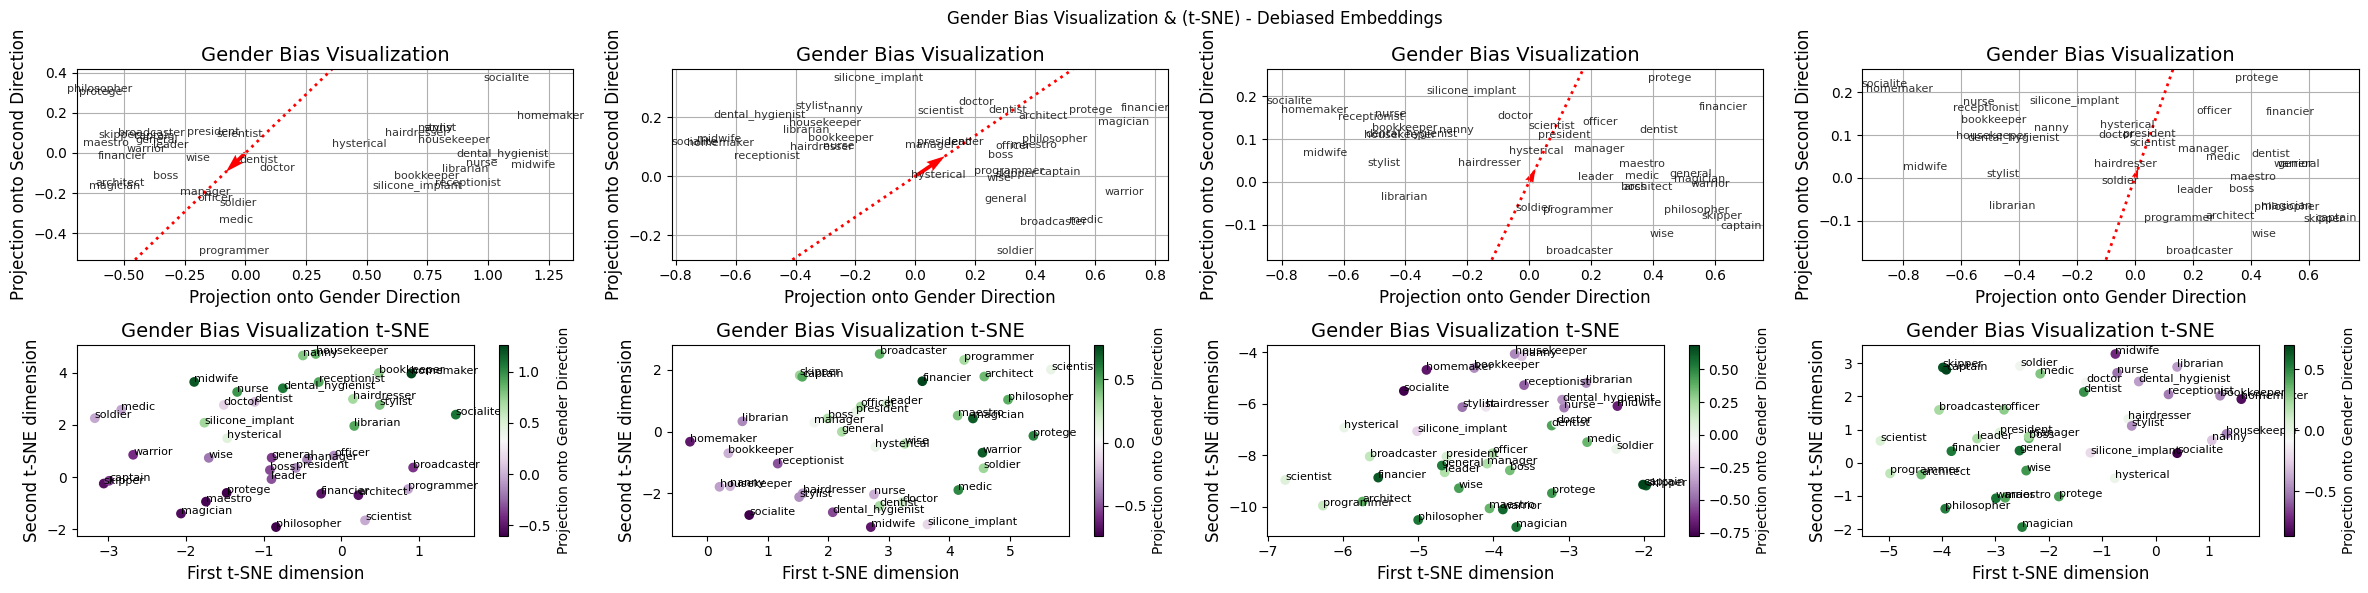

In [25]:
# Decide how many columns
num_subplots_col = 4

fig, axs = plt.subplots(2,num_subplots_col, figsize=(24,6))

# Start by printing the embedding graphs with no training
gender_direction = find_gender_direction()
plot_gender_bias_xy_word2vec(gender_biased_words, gender_direction, fig, axs[0,0])

gender_direction = find_gender_direction()
plot_gender_bias_tsne_word2vec_model(gender_biased_words, gender_direction, fig, axs[1,0])

# Train the model 75 epochs and prints their associated graphds
for i in range(1, num_subplots_col):

    train_model(75)

    debiased_gender_direction = find_gender_direction_debiased()
    plot_gender_bias_xy(gender_biased_words, debiased_gender_direction, fig, axs[0,i])

    debiased_gender_direction = find_gender_direction_debiased()
    plot_gender_bias_tsne(gender_biased_words, debiased_gender_direction, model, fig, axs[1,i])

fig.suptitle("Gender Bias Visualization & (t-SNE) - Debiased Embeddings")
plt.tight_layout()
plt.show()

From above, the first row shows the gender bias vector reducing in scalar value. It is easier to see when printing only one plot at a time but because we wanted to showcase the graph in a single slide.

For the bottom row: the t-SNE graphs show if we can create subgroups with dimensionality reduction. Here we are showing that you can still show that the bias can be split in the embedding. This means that there is still bias that is present even after the biasing.